In [1]:
%load_ext pycodestyle_magic
%flake8_on

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import time
from math import pi
from itertools import product

from sklearn import cluster
from sklearn import metrics
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

import scipy.cluster.hierarchy as shc

import warnings
warnings.filterwarnings('ignore')

c:\Users\charl\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\charl\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\charl\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\charl\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Sommaire : Modélisation <a class="anchor" id="Sommaire"></a>

* [Chargement des données](#Partie1)
* [KMeans](#Partie2)
    * [Clustering RFM](#Partie2_1)
    * [Clustering RFM + Review Score](#Partie2_2)
    * [ACP sur les variables numériques](#Partie2_3)
    * [Clustering ACP](#Partie2_4)
    * [Clustering ACP + Variables Catégorielle](#Partie2_5)
    * [Comparaison des performances](#Partie2_6)
* [DBSCAN](#Partie3)
* [Agglomerative Clustering](#Partie4)

## Chargement des données <a class="anchor" id="Partie1"></a>

In [3]:
df_Clients = pd.read_csv('df_Clients.csv')
df_Clients_std = pd.read_csv('df_Clients_std.csv')
print(df_Clients.shape)
df_Clients.head()

(96243, 18)


,Récence,Fréquence,Montant,Note Moyenne,Montant Moyen,Montant Min,Montant Max,Nombre de commandes,Nombre d'objets Max,Nombre d'objets Total,Autres,Beauté_Santé,Loisirs,Maison,Mobilier,Mode,Nourriture_Boissons,Technologies
0,335.0,13.0,95.37,4.25,31.79,29.99,35.39,2,1,2,0,1,0,1,0,0,0,0
1,335.0,13.0,95.37,4.25,31.79,29.99,35.39,2,1,2,0,1,0,1,0,0,0,0
2,383.0,0.0,29.99,4.00,29.99,29.99,29.99,1,1,1,0,0,0,1,0,0,0,0
3,396.0,0.0,29.99,5.00,29.99,29.99,29.99,1,1,1,0,0,0,1,0,0,0,0
4,314.0,0.0,29.99,3.00,29.99,29.99,29.99,1,1,1,0,0,0,1,0,0,0,0


In [4]:
df_Clients.describe()

,Récence,Fréquence,Montant,Note Moyenne,Montant Moyen,Montant Min,Montant Max,Nombre de commandes,Nombre d'objets Max,Nombre d'objets Total,Autres,Beauté_Santé,Loisirs,Maison,Mobilier,Mode,Nourriture_Boissons,Technologies
count,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000,96243.000000
mean,240.993329,2.541910,139.195745,4.107064,125.909921,123.058301,129.000570,1.069034,1.151325,1.317675,0.146546,0.157383,0.142774,0.227985,0.094251,0.096610,0.010671,0.161394
std,152.971768,16.744509,208.321401,1.318027,188.540356,187.650848,192.057748,0.359052,0.556581,1.352754,0.353654,0.364163,0.349844,0.419535,0.292179,0.295427,0.102748,0.367895
min,0.000000,0.000000,0.850000,1.000000,0.850000,0.850000,0.850000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,117.000000,0.000000,45.900000,4.000000,43.000000,39.900000,44.900000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,221.000000,0.000000,86.250000,5.000000,79.200000,75.000000,79.900000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,349.000000,0.000000,150.000000,5.000000,139.900000,137.000000,143.995000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,728.000000,304.000000,7388.000000,5.000000,6735.000000,6735.000000,6735.000000,15.000000,21.000000,77.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


[Retour au sommaire](#Sommaire)

## Modélisation kMeans <a class="anchor" id="Partie2"></a>

In [5]:
def MethodeClusters(df_std, titre, k=0):
    Xstd = df_std.copy()

    if k == 0:
        model = KMeans(random_state=18)
        visualizer = KElbowVisualizer(model, k=(2, 15),
                                      timings=False,
                                      locate_elbow=False).fit(Xstd)
        visualizer.show()

        input_ = input(
            "Entrez le nombre de clusters choisi par méthode du coude: ")
        n = int(input_)
    else:
        n = k

    Titre = titre + ' : ' + str(n) + ' clusters'
    perf = [Titre]

    kmeans = KMeans(n_clusters=n, init='k-means++', random_state=18)
    kmeans.fit(Xstd)
    label = kmeans.labels_
    score = metrics.silhouette_score(Xstd, label, metric='euclidean')
    print('Coefficient de Silhouette moyen : %.3f' % score)
    perf.append(score)

    return perf, kmeans, label

In [6]:
nombre_clients_total = df_Clients.shape[0]


def my_fmt(x):
    return '{:.1f}% ({:.0f})'.format(x, nombre_clients_total*x/100)

In [7]:
def AfficheClusters(df, a, b, model, labels):
    X = df.copy()

    couleur = ['blue', 'green', 'red', 'yellow', 'gray', 'purple', 'pink']
    # cmap = matplotlib.cm.get_cmap('tab10')
    # couleurs = [cmap(0.1*i) for i in range(10)]

    # Silhouette
    visualizer = SilhouetteVisualizer(model, colors=couleur)
    visualizer.fit(X)
    visualizer.show()

    X['Cluster'] = labels
    clust = np.unique(labels)

    # Nombre de clients par cluster
    clusters = X['Cluster'].value_counts(normalize=False)
    cat = pd.DataFrame({'catégorie':  clusters.index, 'nombre': clusters})
    cat = cat.sort_values(by='catégorie')
    cat = cat.reset_index()
    cat = cat.drop(cat.columns[0], axis=1)
    values = cat['nombre']
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('equal')
    ax.pie(values, labels=[('Cluster ' + str(c)) for c in clust],
           autopct=my_fmt, colors=couleur)
    plt.title('Nombre de clients par cluster')
    plt.show()

    # Forme des clusters
    tsne = TSNE(n_components=2, init='pca', n_jobs=-1)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(8, 8))
    sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=labels)

    medianprops = {'color': "black"}
    meanprops = {'marker': 'o', 'markeredgecolor': 'black',
                 'markerfacecolor': 'firebrick'}

    # Boxplot
    fig, axes = plt.subplots(a, b)
    fig.set_figwidth(8*b)
    fig.set_figheight(6*a)
    count = 0
    for variable in X.columns[:-1]:
        groupes = []
        for c in clust:
            groupes.append(X[X['Cluster'] == c][variable])
        if a == 1:
            axes[count].boxplot(groupes, labels=clust, showfliers=False,
                                medianprops=medianprops, vert=False,
                                patch_artist=True, showmeans=True,
                                meanprops=meanprops)
            axes[count].set_xlabel(variable)
            axes[count].set_ylabel('Clusters')
            axes[count].set_title(variable + ' par cluster', fontsize=15)
        else:
            axes[int(np.floor(count/b)), (count % b)].boxplot(
                groupes, labels=clust, showfliers=False,
                medianprops=medianprops, vert=False, patch_artist=True,
                showmeans=True, meanprops=meanprops)
            axes[int(np.floor(count/b)), (count % b)].set_xlabel(variable)
            axes[int(np.floor(count/b)), (count % b)].set_ylabel('Clusters')
            axes[int(np.floor(count/b)), (count % b)].set_title(
                variable + ' par cluster', fontsize=15)
        plt.xticks(rotation=0)
        count = count + 1
    plt.show()

    # Moyenne par cluster (Graphe linéaire)
    cluster = []
    vecteurCluster = []
    for c in clust:
        vec = X[X['Cluster'] == c]
        cluster.append(vec)
        listeMean = []
        for variable in X.columns[:-1]:
            listeMean.append(vec[variable].mean())
        vecteurCluster.append(listeMean)

    n1 = 2*X.shape[1]
    x = np.arange(2, n1, 2)
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    x_ticks_labels = X.columns[:-1]
    legende = []

    for i in range(len(clust)):
        plt.plot(x, vecteurCluster[i], c=couleur[i], marker='*')
        legende.append(('Cluster ' + str(i)))
    plt.legend(legende, loc="upper right", fontsize=15)
    plt.title("Moyenne des variables par clusters",
              fontsize=20)
    plt.xlabel("Variable", fontsize=15)
    plt.ylabel("Moyenne des variables", fontsize=15)
    ax.set_xticks(x)
    plt.tick_params(axis='both', labelsize=20)
    ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=15)

[Retour au sommaire](#Sommaire)

### Clustering RFM <a class="anchor" id="Partie2_1"></a>

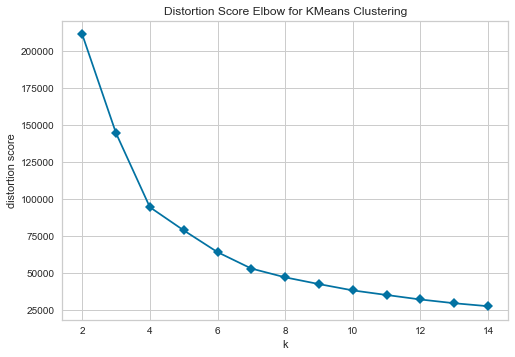

Coefficient de Silhouette moyen : 0.476


In [8]:
perf_RFM, kmeans_RFM, labels_RFM, n_RFM = MethodeClusters(
    df_Clients_std[['Récence', 'Fréquence', 'Montant']],
    'RFM')

In [9]:
AfficheClusters(df_Clients_std[['Récence', 'Fréquence', 'Montant']],
                1, 3, kmeans_RFM, labels_RFM, n_RFM)

AttributeError: 'NoneType' object has no attribute 'split'

- Les clients du cluster étiqueté *0* présentent une haute récence (donc leur dernière date d'achat est assez lointaine), une faible fréquence et un faible montant. Ils représentent donc des clients **perdus depuis longtemps**.
- Les clients du cluster étiqueté *1* sont des clients qui ont un montant d'achat élevé. Ils ne commandent pas fréquemment. Ce sont donc les clients **à ne pas perdre**.
- Les clients du cluster étiqueté *2* sont des clients qui commandent régulièrement pour un montant d'achat modeste. Ils représentent les clients **fidèles**.
- Les clients du cluster étiqueté *3* sont des clients récents qui ne commandent pas fréquemment et pour un faible montant. Ce sont des clients **potentiellement fidèles**.

[Retour au sommaire](#Sommaire)

### Clustering RFM + review score <a class="anchor" id="Partie2_2"></a>

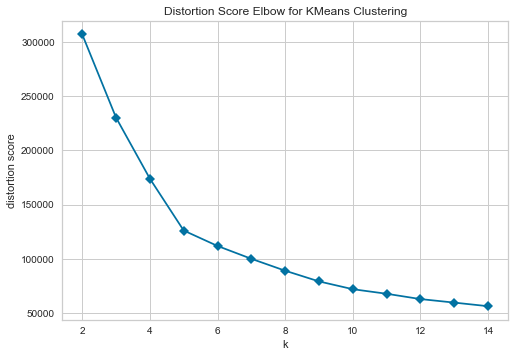

Entrez le nombre de clusters choisi par méthode du coude: 5
Coefficient de Silhouette moyen : 0.406


In [ ]:
perf_RFM_Note, kmeans_RFM_Note, labels_RFM_Note = MethodeClusters(
    df_Clients_std[['Récence', 'Fréquence', 'Montant', 'Note Moyenne']],
    'RFM + Note Moyenne')

[Retour au sommaire](#Sommaire)

### ACP sur les variables numériques <a class="anchor" id="Partie2_3"></a>

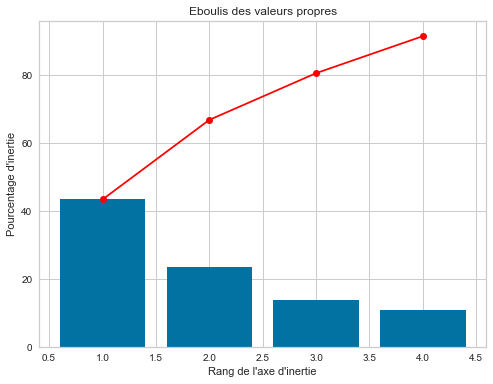

[43.37 66.8  80.56 91.47]


In [ ]:
colonnes_ACP = ['Récence', 'Fréquence', 'Montant', 'Nombre de commandes',
                'Montant Moyen', 'Montant Min', 'Montant Max',
                'Nombre d\'objets Total', 'Nombre d\'objets Max']
df_Clients_ = df_Clients_std[colonnes_ACP]
X = df_Clients_.values

pca = decomposition.PCA(n_components=0.90)
pca.fit(X)
features = df_Clients_.columns

# Eboulis des valeurs propres
scree = pca.explained_variance_ratio_*100
plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(), c='red', marker='o')
plt.xlabel('Rang de l\'axe d\'inertie')
plt.ylabel('Pourcentage d\'inertie')
plt.title('Eboulis des valeurs propres')
plt.show(block=False)

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

X_projected = pca.transform(X)

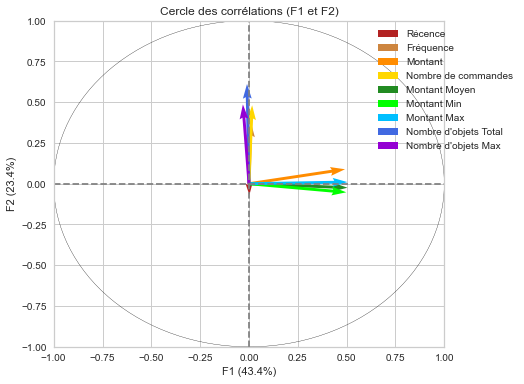

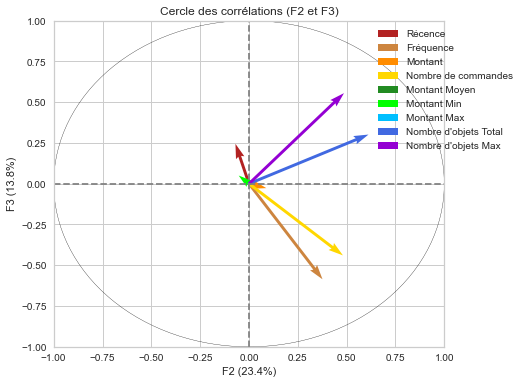

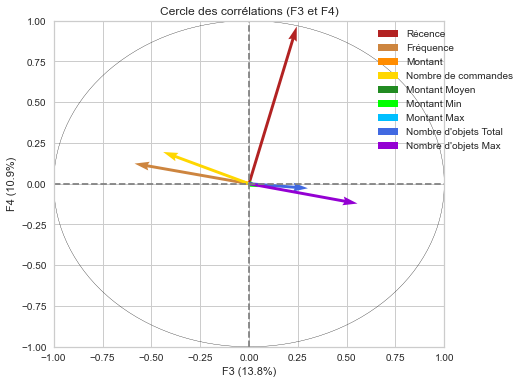

In [ ]:
# Cercle des corrélations
pcs = pca.components_
couleurs = ['firebrick', 'peru', 'darkorange', 'gold', 'forestgreen', 'lime',
            'deepskyblue', 'royalblue', 'darkviolet', 'deeppink']

for d1, d2 in [(0, 1), (1, 2), (2, 3)]:
    if d2 < X_projected.shape[1]:
        # initialisation de la figure
        fig, ax = plt.subplots(figsize=(7, 6))

        # détermination des limites du graphique
        if pcs.shape[1] < 30:
            xmin, xmax, ymin, ymax = -1, 1, -1, 1
        else:
            xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(pcs[d1, :]),
            min(pcs[d2, :]), max(pcs[d2, :])

        # affichage des noms des variables
        for i, (x, y) in enumerate(pcs[[d1, d2]].T):
            if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                plt.quiver(0, 0, pcs[d1, i], pcs[d2, i], angles='xy',
                           scale_units='xy', scale=1, color=couleurs[i])
        plt.legend(np.array(features), loc='best', bbox_to_anchor=(1.2, 1))

        # affichage du cercle
        circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='black')
        plt.gca().add_artist(circle)

        # définition des limites du graphique
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        # affichage des lignes horizontales et verticales
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        # nom des axes, avec le pourcentage d'inertie expliqué
        plt.xlabel('F{} ({}%)'.format(
            d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
        plt.ylabel('F{} ({}%)'.format(
            d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

        plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
        plt.show(block=False)

In [ ]:
df_ACP = pd.DataFrame(X_projected[:, :4])
colonnes = []
for i in range(df_ACP.shape[1]):
    colonnes.append('Facteur ' + str(i+1))
df_ACP.columns = colonnes

[Retour au sommaire](#Sommaire)

### Clustering ACP <a class="anchor" id="Partie2_4"></a>

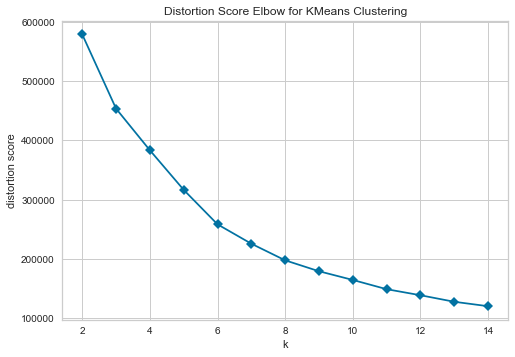

Entrez le nombre de clusters choisi par méthode du coude: 4
Coefficient de Silhouette moyen : 0.605


In [ ]:
perf_ACP, kmeans_ACP, labels_ACP = MethodeClusters(
    df_ACP, 'ACP')

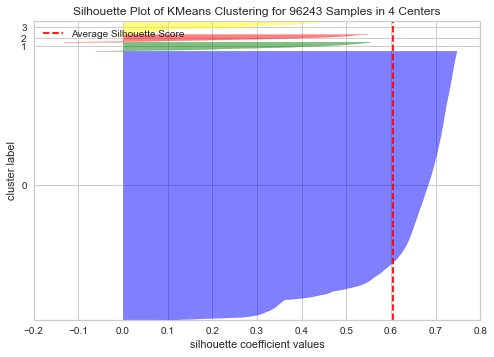

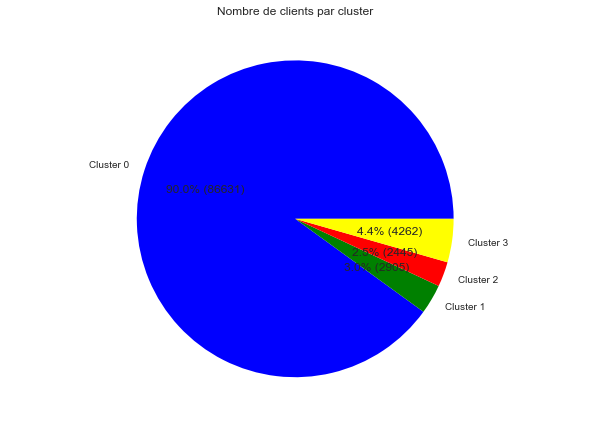

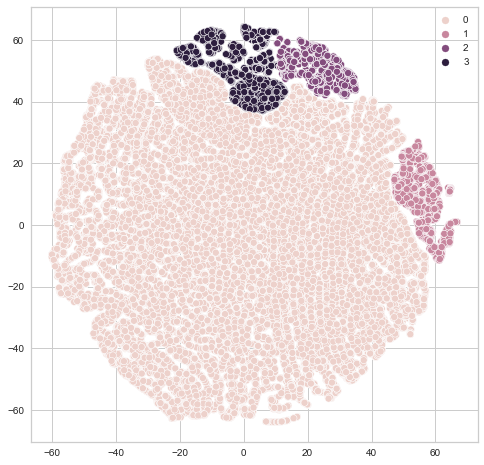

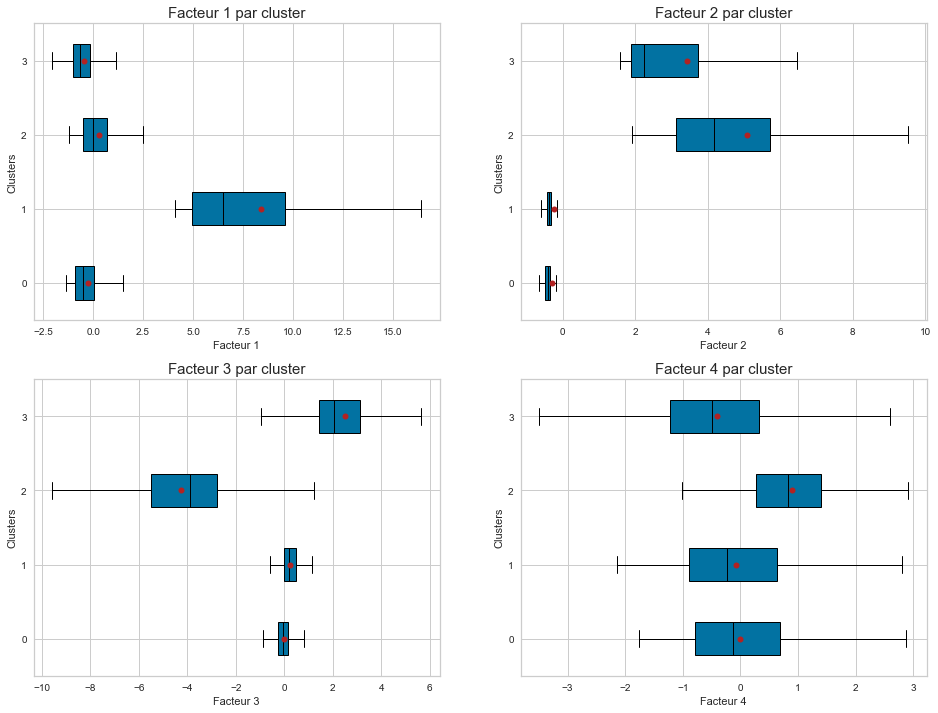

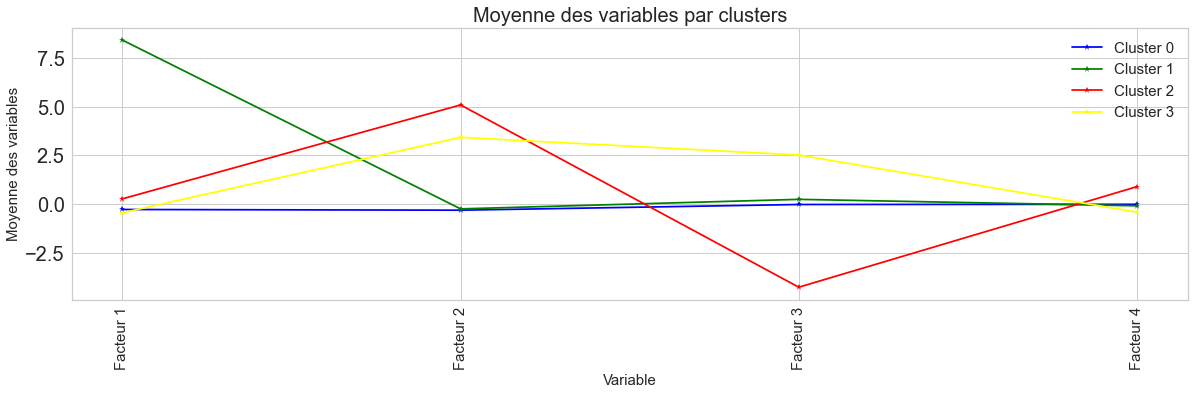

In [ ]:
AfficheClusters(df_ACP, 2, 2, kmeans_ACP, labels_ACP)

- Les clients du cluster étiqueté *0* ont des valeurs faibles pour tous les facteurs. Ils représentent donc des clients **perdus**.
- Les clients du cluster étiqueté *1* ont un facteur 1 élevé. Grâce à l'étude des cercles des corrélations de l'ACP, nous savons que le facteur 1 est très corrélé au montant d'achat. Les autres facteurs des clients du cluster sont proches de 0. Les clients n'ont donc pas acheté à plusieurs reprises ni de nombreux objets. Ce sont donc les clients **à ne pas perdre**.
- Les clients du cluster étiqueté *2* ont un facteur 2 élevé et un facteur 3 très faible. Ce sont donc des clients qui achètent fréquemment sur le site et qui ont acheté beaucoup d'objets. Ils représentent donc des clients **fidèles**.
- Les clients du cluster étiqueté *3* ont un facteur 2 relativement elevé et un facteur 3 très élevé. Ils ont achetés plusieurs objets en plusieurs commandes et pour un montant d'achat faible. Ce sont les clients **potentiellement fidèles**.

[Retour au sommaire](#Sommaire)

### Clustering ACP + catégorielle <a class="anchor" id="Partie2_5"></a>

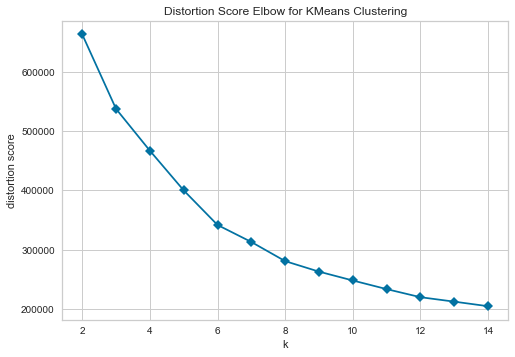

Entrez le nombre de clusters choisi par méthode du coude: 4
Coefficient de Silhouette moyen : 0.532


In [ ]:
df_ACP_cat = df_ACP.join(
    df_Clients[['Autres', 'Beauté_Santé', 'Loisirs', 'Maison', 'Mobilier',
                'Mode', 'Nourriture_Boissons',
                'Technologies']].reset_index(drop=True))

perf_ACP_cat, kmeans_ACP_cat, labels_cat = MethodeClusters(
    df_ACP_cat, 'ACP + variable catégorielle')

[Retour au sommaire](#Sommaire)

### Comparaison des performances <a class="anchor" id="Partie2_6"></a>

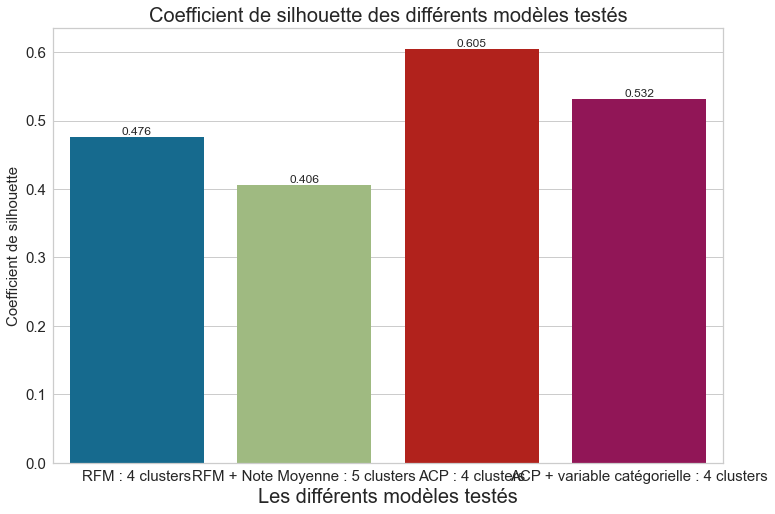

In [ ]:
listePerf = [perf_RFM, perf_RFM_Note, perf_ACP, perf_ACP_cat]
listeModeles = []
listeSilh = []

for perf in listePerf:
    listeModeles.append(perf[0])
    listeSilh.append(np.round(perf[1], decimals=3))

fig = plt.figure(figsize=(12, 8))
ax = sns.barplot(x=listeModeles, y=listeSilh)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Coefficient de silhouette des différents modèles testés',
          fontsize=20)
plt.xlabel('Les différents modèles testés', fontsize=20)
plt.ylabel('Coefficient de silhouette', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.xticks(rotation=45)
plt.show()

[Retour au sommaire](#Sommaire)

## DBSCAN <a class="anchor" id="Partie3"></a>

In [ ]:
df_Clients_opt = df_ACP.sample(n=50000, random_state=0)

In [ ]:
df_Clients_opt.head()

,Facteur 1,Facteur 2,Facteur 3,Facteur 4
39688,-0.090167,-0.361831,-0.297559,-1.000867
14177,0.220330,-0.342082,-0.349176,-1.250305
9739,1.109304,-0.426867,0.001093,0.000725
28430,-0.855537,-0.597283,0.487865,2.211037
93682,1.151421,-0.431121,0.018527,0.063303


In [ ]:
def PerformDBSCAN(df_std, a, b, params):
    df1std = df_std.copy()
    Xstd = df1std.sample(n=15000, random_state=42)

    N_clus = []
    sil_score = []

    for p in params:
        eps = p[0]
        n = p[1]

        dbscan_cluster = DBSCAN(eps=eps, min_samples=n)
        dbscan_cluster.fit(Xstd)

        # Number of Clusters
        labels = dbscan_cluster.labels_
        N_clus.append(len(np.unique(labels)))

        sil_score.append(metrics.silhouette_score(Xstd,
                                                  labels))
    temp = pd.DataFrame.from_records(params,
                                     columns=['eps', 'min_samples'])
    temp['Nombre de clusters'] = N_clus

    fig, axes = plt.subplots(figsize=(12, 6))
    sns.heatmap(pd.pivot_table(temp, values='Nombre de clusters',
                               index='min_samples', columns='eps'),
                annot=True, annot_kws={"size": 16}, cmap="YlGnBu", ax=axes)
    axes.set_title('Nombre de clusters')
    plt.show()

    temp = pd.DataFrame.from_records(params,
                                     columns=['eps', 'min_samples'])
    temp['Coefficient de Silhouette'] = sil_score

    fig, ax = plt.subplots(figsize=(18, 6))
    sns.heatmap(pd.pivot_table(temp, values='Coefficient de Silhouette',
                               index='min_samples', columns='eps'),
                annot=True, annot_kws={"size": 10},
                cmap="YlGnBu", ax=ax)
    plt.show()

In [ ]:
nombre_clients_total2 = df_Clients_opt.shape[0]


def my_fmt2(x):
    return '{:.1f}% ({:.0f})'.format(x, nombre_clients_total2*x/100)

In [ ]:
def Best_DBSCAN(dfstd, a, b, eps, n):
    Xstd = dfstd.copy()

    print('Clustering DBSCAN pour les meilleurs hyperparamètres...')
    DBSCAN_ = DBSCAN(eps=eps, min_samples=n, n_jobs=-1).fit(Xstd)
    label = DBSCAN_.labels_

    print('Calcul du coefficient de silhouette...')
    score = metrics.silhouette_score(Xstd, label)
    print('Coefficient de Silhouette moyen : %.3f' % score)

    Xstd['Cluster'] = label
    clust = np.unique(label)

    cmap = matplotlib.cm.get_cmap('tab10')
    couleurs = [cmap(0.1*i) for i in range(10)]

    # Nombre de clients par cluster
    clusters = Xstd['Cluster'].value_counts(normalize=False)
    cat = pd.DataFrame({'catégorie':  clusters.index, 'nombre': clusters})
    cat = cat.sort_values(by='catégorie')
    cat = cat.reset_index()
    cat = cat.drop(cat.columns[0], axis=1)
    values = cat['nombre']
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('equal')
    ax.pie(values, labels=[('Cluster ' + str(c)) for c in clust],
           autopct=my_fmt2, colors=couleurs)
    plt.title('Nombre de clients par cluster')
    plt.show()

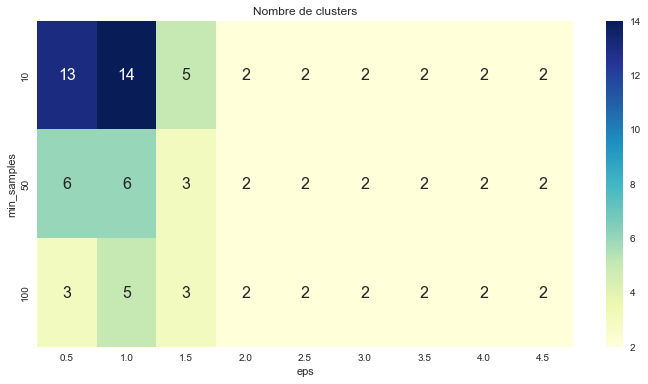

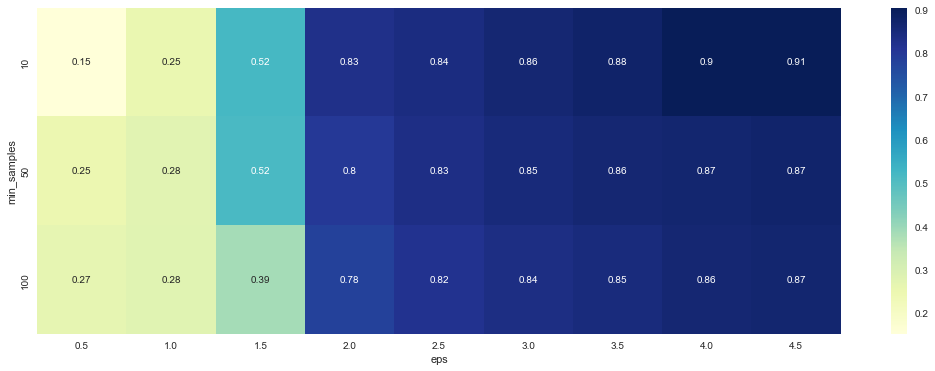

In [ ]:
eps_values = np.arange(0.5, 5, 0.5)
min_samples = [10, 50, 100]
DBSCAN_params = list(product(eps_values, min_samples))

PerformDBSCAN(df_Clients_opt,
              2, 2, DBSCAN_params)

Clustering DBSCAN pour les meilleurs hyperparamètres...
Calcul du coefficient de silhouette...
Coefficient de Silhouette moyen : 0.768


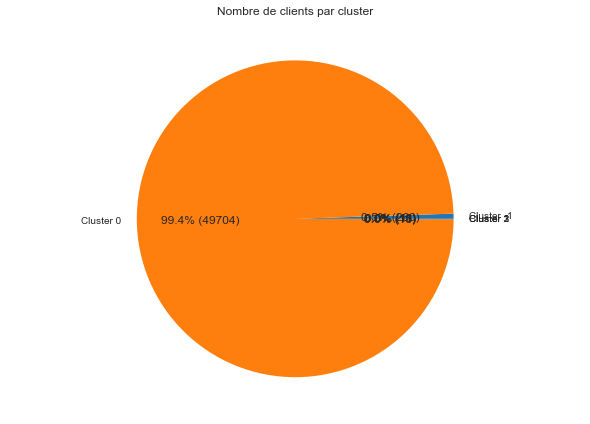

In [ ]:
Best_DBSCAN(df_Clients_opt, 1, 3, 1.5, 10)

[Retour au sommaire](#Sommaire)

## Agglomerative Clustering <a class="anchor" id="Partie4"></a>

In [ ]:
df_Clients_opt2 = df_ACP.sample(n=50000, random_state=0)

In [ ]:
nombre_clients_total3 = df_Clients_opt2.shape[0]


def my_fmt3(x):
    return '{:.1f}% ({:.0f})'.format(x, nombre_clients_total3*x/100)

In [ ]:
def AgglomerativeClust(df, nb_clusters):
    X = df.copy()

    model = AgglomerativeClustering(n_clusters=nb_clusters)
    print('Entraînement du clustering agglomératif...')
    ac = model.fit(X)
    label = ac.labels_

    print('Calcul du coefficient de silhouette...')
    score = metrics.silhouette_score(X, label)
    print('Coefficient de Silhouette moyen : %.3f' % score)

    return score, ac, label

In [ ]:
def AfficheClustersAgglo(df, a, b, labels):
    X = df.copy()

    couleur = ['blue', 'green', 'red', 'yellow', 'gray', 'purple', 'pink']
    # cmap = matplotlib.cm.get_cmap('tab10')
    # couleurs = [cmap(0.1*i) for i in range(10)]

    X['Cluster'] = labels
    clust = np.unique(labels)

    # Nombre de clients par cluster
    clusters = X['Cluster'].value_counts(normalize=False)
    cat = pd.DataFrame({'catégorie':  clusters.index, 'nombre': clusters})
    cat = cat.sort_values(by='catégorie')
    cat = cat.reset_index()
    cat = cat.drop(cat.columns[0], axis=1)
    values = cat['nombre']
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('equal')
    ax.pie(values, labels=[('Cluster ' + str(c)) for c in clust],
           autopct=my_fmt, colors=couleur)
    plt.title('Nombre de clients par cluster')
    plt.show()

    # Forme des clusters
    tsne = TSNE(n_components=2, init='pca', n_jobs=-1)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(8, 8))
    sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=labels)

    medianprops = {'color': "black"}
    meanprops = {'marker': 'o', 'markeredgecolor': 'black',
                 'markerfacecolor': 'firebrick'}

    # Boxplot
    fig, axes = plt.subplots(a, b)
    fig.set_figwidth(8*b)
    fig.set_figheight(6*a)
    count = 0
    for variable in X.columns[:-1]:
        groupes = []
        for c in clust:
            groupes.append(X[X['Cluster'] == c][variable])
        if a == 1:
            axes[count].boxplot(groupes, labels=clust, showfliers=False,
                                medianprops=medianprops, vert=False,
                                patch_artist=True, showmeans=True,
                                meanprops=meanprops)
            axes[count].set_xlabel(variable)
            axes[count].set_ylabel('Clusters')
            axes[count].set_title(variable + ' par cluster', fontsize=15)
        else:
            axes[int(np.floor(count/b)), (count % b)].boxplot(
                groupes, labels=clust, showfliers=False,
                medianprops=medianprops, vert=False, patch_artist=True,
                showmeans=True, meanprops=meanprops)
            axes[int(np.floor(count/b)), (count % b)].set_xlabel(variable)
            axes[int(np.floor(count/b)), (count % b)].set_ylabel('Clusters')
            axes[int(np.floor(count/b)), (count % b)].set_title(
                variable + ' par cluster', fontsize=15)
        plt.xticks(rotation=0)
        count = count + 1
    plt.show()

    # Moyenne par cluster (Graphe linéaire)
    cluster = []
    vecteurCluster = []
    for c in clust:
        vec = X[X['Cluster'] == c]
        cluster.append(vec)
        listeMean = []
        for variable in X.columns[:-1]:
            listeMean.append(vec[variable].mean())
        vecteurCluster.append(listeMean)

    n1 = 2*X.shape[1]
    x = np.arange(2, n1, 2)
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    x_ticks_labels = X.columns[:-1]
    legende = []

    for i in range(len(clust)):
        plt.plot(x, vecteurCluster[i], c=couleur[i], marker='*')
        legende.append(('Cluster ' + str(i)))
    plt.legend(legende, loc="upper right", fontsize=15)
    plt.title("Moyenne des variables par clusters",
              fontsize=20)
    plt.xlabel("Variable", fontsize=15)
    plt.ylabel("Moyenne des variables", fontsize=15)
    ax.set_xticks(x)
    plt.tick_params(axis='both', labelsize=20)
    ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=15)

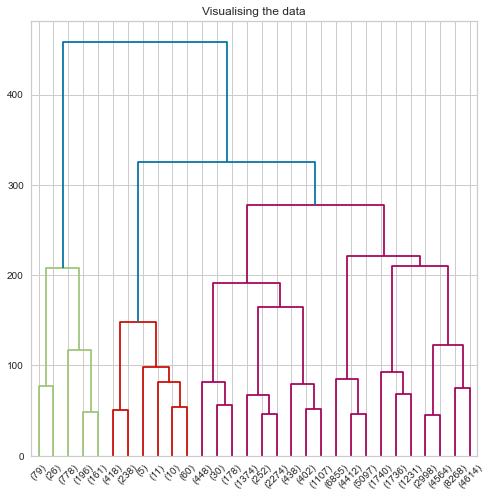

In [ ]:
plt.figure(figsize=(8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(df_Clients_opt2, method='ward')),
                            truncate_mode='lastp')

In [ ]:
Silh3, AC3, labels_AC3 = AgglomerativeClust(df_Clients_opt2, 3)

Entraînement du clustering agglomératif...
Calcul du coefficient de silhouette...
Coefficient de Silhouette moyen : 0.738


In [ ]:
Silh4, AC4, labels_AC4 = AgglomerativeClust(df_Clients_opt2, 4)

Entraînement du clustering agglomératif...
Calcul du coefficient de silhouette...
Coefficient de Silhouette moyen : 0.475


In [ ]:
Silh5, AC5, labels_AC5 = AgglomerativeClust(df_Clients_opt2, 5)

Entraînement du clustering agglomératif...
Calcul du coefficient de silhouette...
Coefficient de Silhouette moyen : 0.266


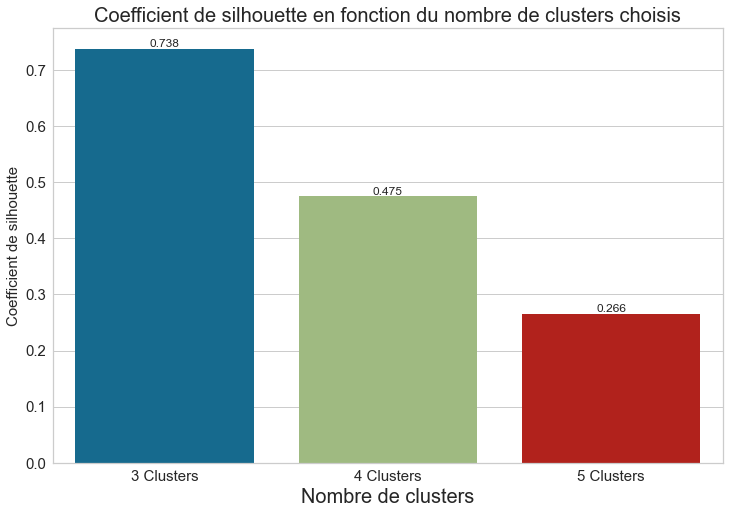

In [ ]:
listeModeles = ['3 Clusters', '4 Clusters', '5 Clusters']
listeSilh = [Silh3, Silh4, Silh5]
listeSilh = np.round(listeSilh, decimals=3)

fig = plt.figure(figsize=(12, 8))
ax = sns.barplot(x=listeModeles, y=listeSilh)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Coefficient de silhouette en fonction '
          'du nombre de clusters choisis',
          fontsize=20)
plt.xlabel('Nombre de clusters', fontsize=20)
plt.ylabel('Coefficient de silhouette', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.xticks(rotation=45)
plt.show()

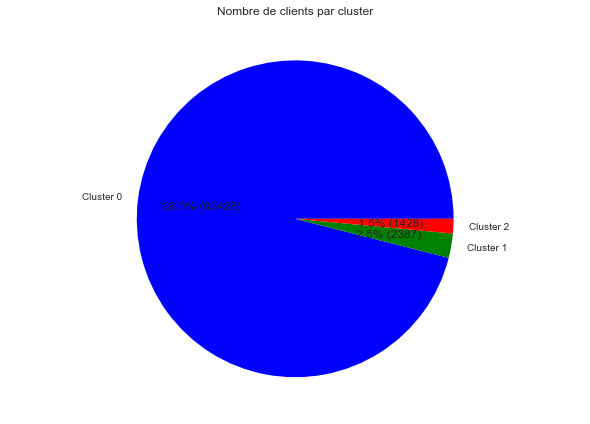

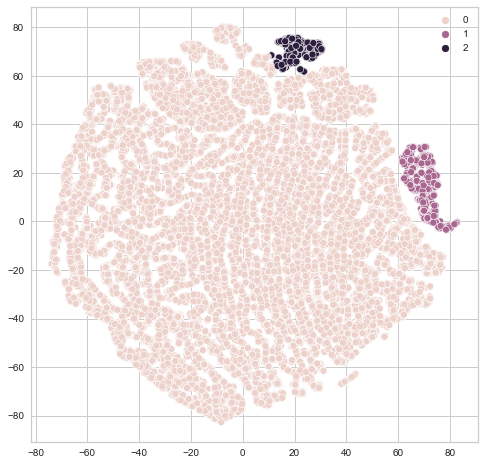

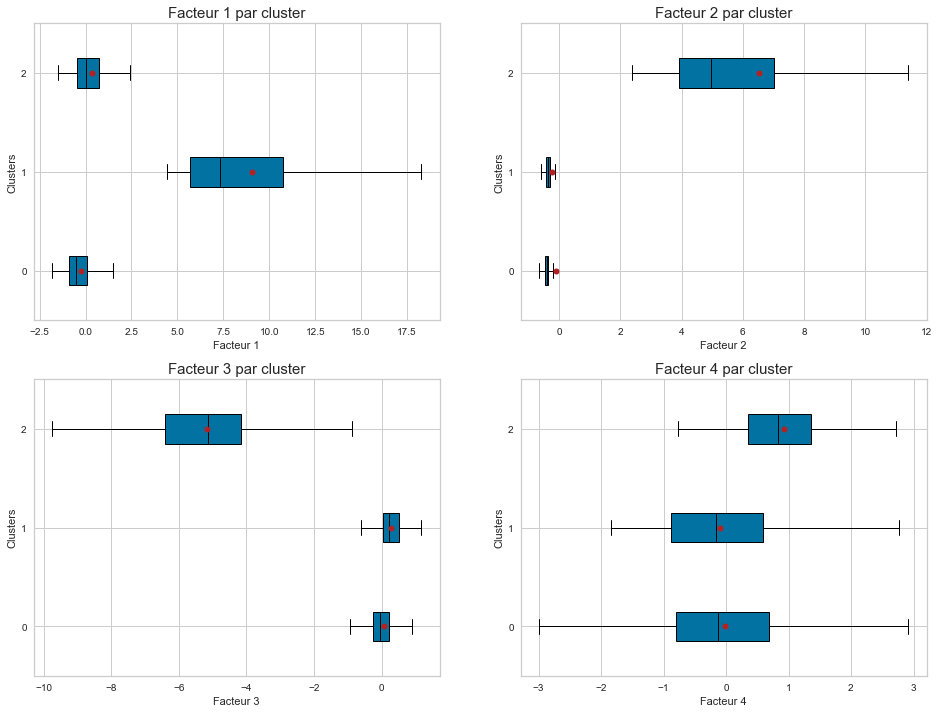

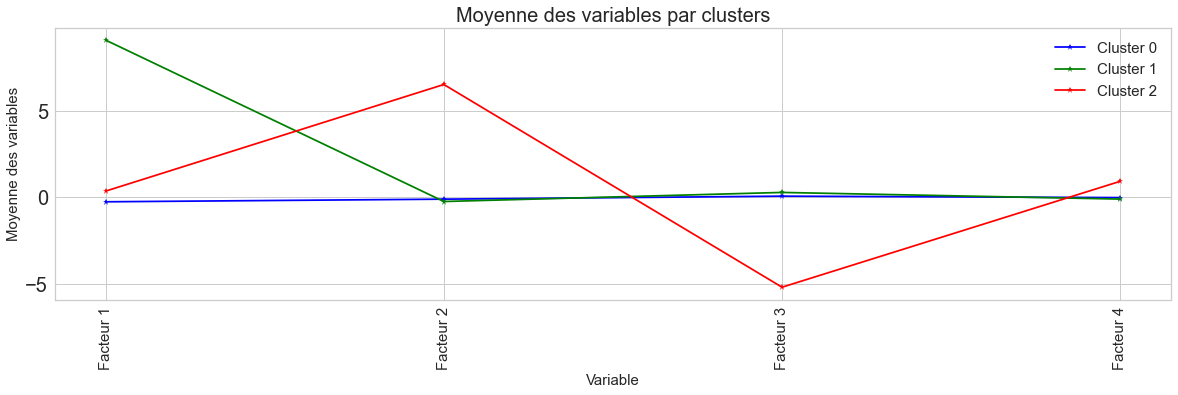

In [ ]:
AfficheClustersAgglo(df_Clients_opt2, 2, 2, labels_AC3)